# **FraudSpotter: Job Posting Detection Using NLP & ML Models- BASELINE ML PORTION**

Created By: Maureen Ekwebelem & YaeJin(Sally) Kang

In [ ]:
# Import relevant libraries

# Data handling
import pandas as pd
import numpy as np
import re

# Text processing
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocessing and sampling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack, csr_matrix

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Evaluation metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# SHAP
!pip install shap
import shap

# Visualization- SHAP
import matplotlib.pyplot as plt

In [ ]:
# Import file
df= pd.read_csv("/content/fake_job_postings.csv")

# View the first 5 rows and verify rows & record count
# df.head()
print("Initial shape:", df.shape)

Initial shape: (17880, 18)


In [ ]:
# Data Cleaning

# Remove columns with over 80% missing data
null_counts = df.isna().sum()
missing_percent = (null_counts / len(df)) * 100
high_missing = missing_percent[missing_percent > 80]
df.drop(columns=high_missing.index, inplace=True)

# Remove duplicates
df.drop_duplicates(inplace=True)

# Creating dataframe for ML
df_ml = df.copy()

In [ ]:
# Data Cleaning continued

# Replace all NaN with empty strings
text_columns = ['title', 'location', 'department', 'company_profile',
    'description', 'requirements', 'benefits',
    'employment_type', 'required_experience',
    'required_education', 'industry', 'function'
]

for col in text_columns:
    if col in df_ml.columns:
        df_ml[col] = df_ml[col].fillna('')

# Combine text based columns into one big text column
df_ml['text'] = df_ml[text_columns].astype(str).agg(' '.join, axis=1)

def cleaned_text_ml(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'<[^>]+>', '', text) # remove HTML or XML tags
    text = re.sub(r'http\S+|www\S+', '', text)  # remove URLs
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = re.sub(r'\s+', ' ', text).strip() # tidy up spacing
    return text

df_ml['text_clean'] = df_ml['text'].apply(cleaned_text_ml)
print(df_ml.shape)

(17880, 19)


In [ ]:
# One hot encoding
categorical_cols = [
    'location', 'department', 'employment_type',
    'required_experience', 'required_education',
    'industry', 'function'
]

df_ml[categorical_cols] = df_ml[categorical_cols].fillna('unknown')
encoded_df = pd.get_dummies(df_ml, columns=categorical_cols, drop_first=True)
print("Shape check after encoding:", encoded_df.shape)
encoded_df.select_dtypes(include='object').columns.tolist()

Shape check after encoding: (17880, 4647)


['title',
 'company_profile',
 'description',
 'requirements',
 'benefits',
 'text',
 'text_clean']

In [ ]:
# Create X and y dataframes
y = encoded_df['fraudulent']
X = encoded_df.drop(columns=['fraudulent'])

In [ ]:
# Separate cleaned text data

X_text = X['text_clean']

text_cols_to_drop = [
    'title', 'location', 'department', 'company_profile',
    'description', 'requirements', 'benefits',
    'text', 'text_clean'
]

# Drop raw text columns from structured features
X_struct = X.drop(columns=text_cols_to_drop, errors='ignore')

# Train-test split (stratified)
X_train_text, X_test_text, X_train_struct, X_test_struct, y_train, y_test = train_test_split(
    X_text,
    X_struct,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train size:", len(y_train), "Test size:", len(y_test))

Train size: 14304 Test size: 3576


In [ ]:
# TF-IDF Vectorizer to convert text into numerical features
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

In [ ]:
# Convert structured features to float to prevent errors
X_train_struct = X_train_struct.astype(float)
X_test_struct = X_test_struct.astype(float)

# Combine the TF-IDF and structured features
X_train_combined = hstack([X_train_tfidf, csr_matrix(X_train_struct.values)])
X_test_combined  = hstack([X_test_tfidf,  csr_matrix(X_test_struct.values)])

In [ ]:
# Feature names for SHAP (TF-IDF + structured data)
tfidf_feature_names = tfidf.get_feature_names_out()
struct_feature_names = X_train_struct.columns.astype(str).tolist()
feature_names = np.concatenate([tfidf_feature_names, struct_feature_names])

print("Combined train shape:", X_train_combined.shape)
print("Combined test shape :", X_test_combined.shape)

Combined train shape: (14304, 9639)
Combined test shape : (3576, 9639)


In [ ]:
# Balance data using Random OverSampler (balanced after combining)
ros = RandomOverSampler(random_state=42)
X_train_bal, y_train_bal = ros.fit_resample(X_train_combined, y_train)
print("Balanced train shape check:", X_train_bal.shape)
print("Balanced label counts:", np.bincount(y_train_bal)) # both classes have same count now

Balanced train shape check: (27222, 9639)
Balanced label counts: [13611 13611]


In [ ]:
# XGBoost
xgb = XGBClassifier(eval_metric='logloss', random_state=42,n_estimators=200, learning_rate=0.1)

xgb.fit(X_train_bal, y_train_bal)
y_pred_xgb = xgb.predict(X_test_combined)
y_proba_xgb = xgb.predict_proba(X_test_combined)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba_xgb)

# Evaluation: XGBoost
print("XGBoost Performance")
print(f"ROC-AUC: {roc_auc:.3f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.3f}")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

XGBoost Performance
ROC-AUC: 0.993
Accuracy: 0.987
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3403
           1       0.89      0.83      0.86       173

    accuracy                           0.99      3576
   macro avg       0.94      0.91      0.92      3576
weighted avg       0.99      0.99      0.99      3576

[[3385   18]
 [  30  143]]


In [ ]:
# Scale for Logistic Regression & KNN
scaler = StandardScaler(with_mean=False)   # with_mean=False for sparse matrices
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled  = scaler.transform(X_test_combined)

# Scaled copies for Logistic Regression & KNN
X_train_logreg = X_train_scaled
X_test_logreg  = X_test_scaled

X_train_knn = X_train_scaled
X_test_knn  = X_test_scaled

In [ ]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=300,class_weight='balanced',random_state=42)

log_reg.fit(X_train_logreg, y_train_bal)
y_pred_logreg = log_reg.predict(X_test_logreg)
y_proba_logreg = log_reg.predict_proba(X_test_logreg)[:, 1]

roc_auc = roc_auc_score(y_test, y_proba_logreg)

# Evaluation: Logistic Regression
print("Logistic Regression Performance")
print(f"Accuracy: {accuracy_score(y_test, y_pred_logreg):.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")
print(classification_report(y_test, y_pred_logreg))
print(confusion_matrix(y_test, y_pred_logreg))

Logistic Regression Performance
Accuracy: 0.987
ROC-AUC: 0.991
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.89      0.83      0.86       173

    accuracy                           0.99      3576
   macro avg       0.94      0.91      0.93      3576
weighted avg       0.99      0.99      0.99      3576

[[3386   17]
 [  30  143]]


In [ ]:
# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_knn, y_train_bal)
knn_pred = knn.predict(X_test_knn)
knn_proba = knn.predict_proba(X_test_knn)[:, 1]

roc_auc = roc_auc_score(y_test, knn_proba)

# Evaluation: KNN
print("KNN Performance")
print(f"Accuracy: {accuracy_score(y_test, knn_pred):.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")
print(classification_report(y_test, knn_pred))
print(confusion_matrix(y_test, knn_pred))

KNN Performance
Accuracy: 0.659
ROC-AUC: 0.900
              precision    recall  f1-score   support

           0       1.00      0.64      0.78      3403
           1       0.12      0.98      0.22       173

    accuracy                           0.66      3576
   macro avg       0.56      0.81      0.50      3576
weighted avg       0.96      0.66      0.75      3576

[[2186 1217]
 [   3  170]]


**Model Comparison Summary**  
Both Logistic Regression and XGBoost performed extremely well, achieving around 98.7% accuracy with strong ROC-AUC scores, while KNN performed noticeably worse. Logistic Regression performed only negligibly better than XGBoost, but because it is much easier to interpret with SHAP, we selected it for explainability.

/usr/local/lib/python3.12/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


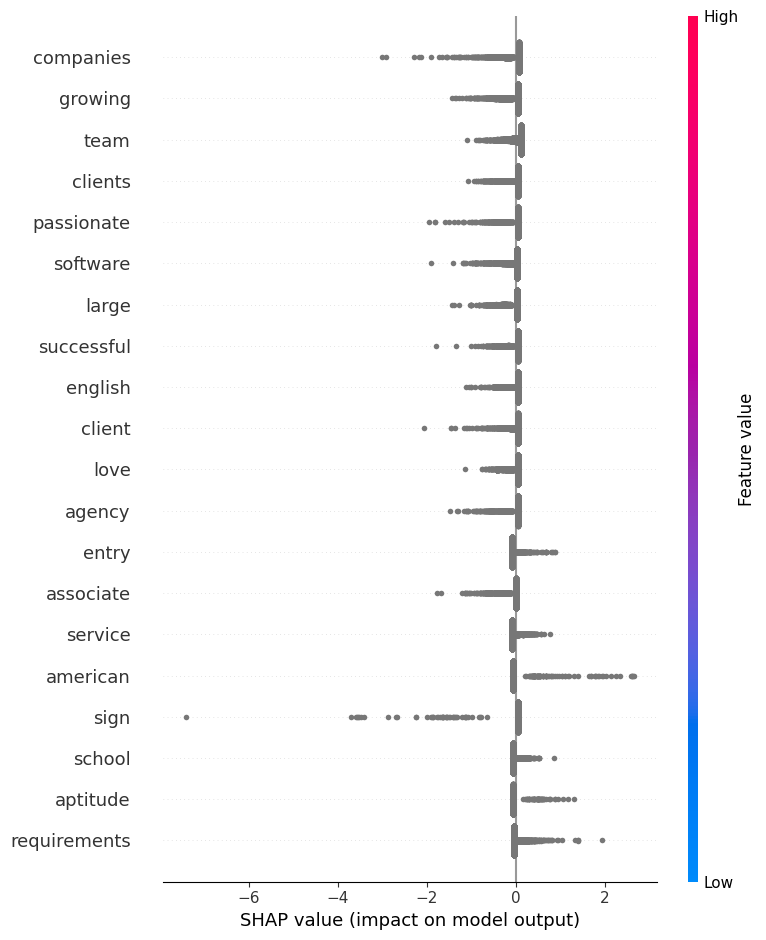

<Figure size 640x480 with 0 Axes>

In [ ]:
# SHAP Explainability for Logistic Regression Model

# Get TF-IDF + structured feature names
tfidf_feature_names = tfidf.get_feature_names_out().tolist()
struct_feature_names = X_train_struct.columns.tolist()
feature_names = tfidf_feature_names + struct_feature_names

# SHAP values for test set
explainer = shap.Explainer(log_reg, X_train_logreg, feature_perturbation="interventional", show=False)
shap_values = explainer(X_test_logreg)
shap_array = shap_values.values

# TF-IDF features only- including structured features for this task would yield little interpretive value
n_tfidf = len(tfidf_feature_names)
shap_array_tfidf = shap_array[:, :n_tfidf]
X_test_tfidf = X_test_logreg[:, :n_tfidf]

# Compute the highest absolute SHAP value per feature
max_abs_shap = np.abs(shap_array_tfidf).max(axis=0)

# Keep only features above a SHAP impact threshold
strong_idx = np.where(max_abs_shap >= 0.75)[0]

shap_array_strong = shap_array_tfidf[:, strong_idx]
X_test_strong = X_test_tfidf[:, strong_idx]
feature_names_strong = [tfidf_feature_names[i] for i in strong_idx]

# Rebuilds SHAP explanation object for these selectively notable feaures
shap_values_strong = shap.Explanation(
    values=shap_array_strong,
    base_values=shap_values.base_values,
    data=X_test_strong,
    feature_names=feature_names_strong
)

# Plot only the most influential words
shap.summary_plot(shap_values_strong, X_test_strong, feature_names=feature_names_strong)
plt.tight_layout()
plt.show()